In [1]:
import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd
import seaborn as sns
import util
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../heart_failure_clinical_records_dataset.csv')

# Filtering and Feature Selection

# Using Pearson Correlation

In [3]:
df_pearson = df.copy(deep=True)

In [4]:
df_pearson.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Pearson Correlation heatmap

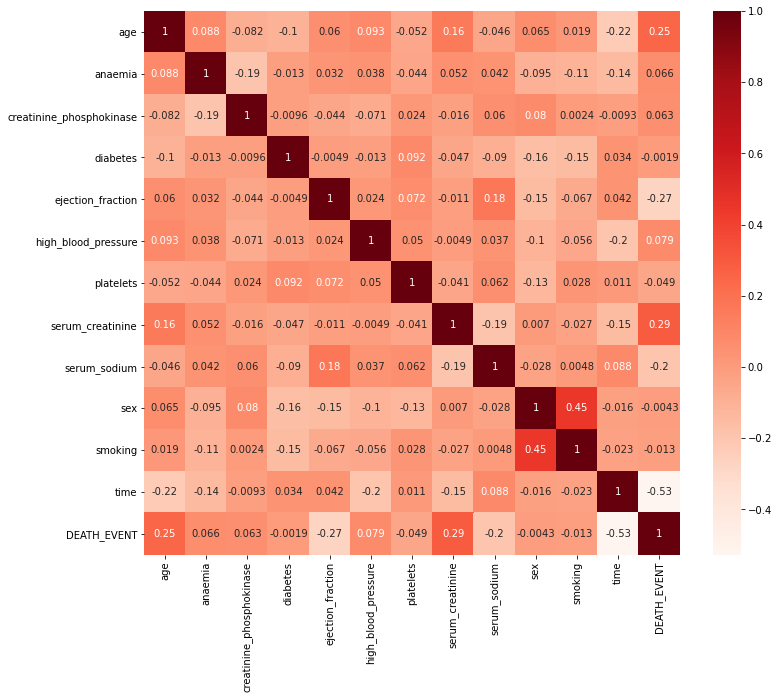

In [5]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_pearson.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Select Features with abs(Correlation Cofficient) Greater than or Equal to 0.2

In [6]:
# Correlation with output variable
cor_target = abs(cor["DEATH_EVENT"])
# Selecting highly correlated features
relevant_features = cor_target[cor_target>=0.2]
relevant_features

age                  0.253729
ejection_fraction    0.268603
serum_creatinine     0.294278
time                 0.526964
DEATH_EVENT          1.000000
Name: DEATH_EVENT, dtype: float64

Check for correlating features

In [7]:
print(df_pearson[['age','ejection_fraction','serum_creatinine','time']].corr())

                        age  ejection_fraction  serum_creatinine      time
age                1.000000           0.060098          0.159187 -0.224068
ejection_fraction  0.060098           1.000000         -0.011302  0.041729
serum_creatinine   0.159187          -0.011302          1.000000 -0.149315
time              -0.224068           0.041729         -0.149315  1.000000


Normalize Datset

In [8]:
# keep dataframe only with relevant features
df_pearson = df_pearson[[i for i in relevant_features.index]]
df_pearson.head()

,age,ejection_fraction,serum_creatinine,time,DEATH_EVENT
0,75.0,20,1.9,4,1
1,55.0,38,1.1,6,1
2,65.0,20,1.3,7,1
3,50.0,20,1.9,7,1
4,65.0,20,2.7,8,1


In [9]:
pearson_normalized = util.norm(df_pearson.copy(deep=True), target='DEATH_EVENT')
pearson_normalized.columns = [n for n in relevant_features.index]
pearson_normalized.head()

,age,ejection_fraction,serum_creatinine,time,DEATH_EVENT
0,1.192945,-1.530560,0.490057,-1.629502,1
1,-0.491279,-0.007077,-0.284552,-1.603691,1
2,0.350833,-1.530560,-0.090900,-1.590785,1
3,-0.912335,-1.530560,0.490057,-1.590785,1
4,0.350833,-1.530560,1.264666,-1.577879,1


# (Pearson) Oversampling Techniques

In [10]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC,
                                    KMeansSMOTE)
from imblearn.over_sampling import RandomOverSampler

# (Pearson) RandomOverSampling

In [11]:
dfRandomPearson = pearson_normalized.copy(deep=True)

In [12]:
# initiate RandomOverSampler
ROS = RandomOverSampler()

# split dataset into X and y
y = dfRandomPearson.pop('DEATH_EVENT')
X = dfRandomPearson
y.head()
X_resampled, y_resampled = ROS.fit_resample(X, y)
dfRandPearsRes = pd.DataFrame(X_resampled, columns=X.columns)
dfRandPearsRes['DEATH_EVENT'] = y_resampled
y = dfRandPearsRes['DEATH_EVENT']
X = dfRandPearsRes[[i for i in dfRandPearsRes.columns if i != 'DEATH_EVENT']]

Train/Test Split

In [13]:
from sklearn.model_selection import train_test_split
trainPrand, testPrand = train_test_split(dfRandPearsRes, test_size=0.2)
y_trainPrand = trainPrand.pop('DEATH_EVENT')
X_trainPrand = trainPrand
y_testPrand = testPrand.pop('DEATH_EVENT')
X_testPrand = testPrand

In [14]:
X_trainPrand.head()

,age,ejection_fraction,serum_creatinine,time
398,-0.912335,-0.684180,-0.187726,-1.268139
177,-0.996547,1.008578,-0.381379,0.216033
292,-0.743913,-0.007077,-0.381379,1.648581
144,0.940312,-1.107370,0.296405,-0.248578
222,-1.586025,-0.260991,-0.284552,0.912948


# (Pearson)(RandomOverSampler)
# Classification with SVC, Gaussian Kernel

Select Proper Parameters (C and gamma)

In [15]:
C_range = np.logspace(-3, 3, 13)
gamma_range = np.logspace(-9, 3, 13)

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [17]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 10.0, 'gamma': 10.0} with a score of 0.92


Fit Model

In [18]:
clf_pearson_rand = SVC(gamma=grid.best_params_['C'], C=grid.best_params_['gamma'])
clf_pearson_rand.fit(X_trainPrand, y_trainPrand)

SVC(C=10.0, gamma=10.0)

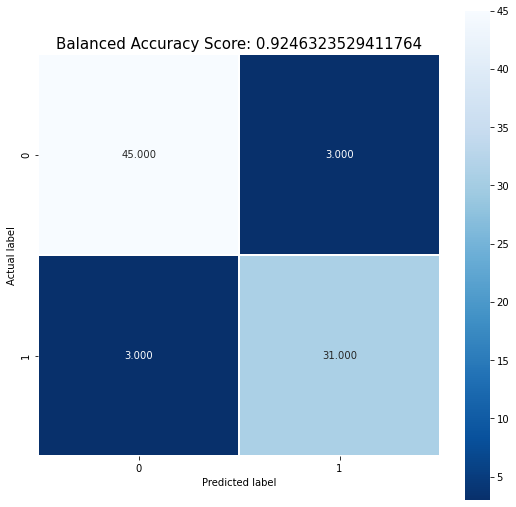

In [19]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix

# make prediction
pred_pears_rand = clf_pearson_rand.predict(X_testPrand)

# calculate ballanced accuracy
bscore_pears_rand = balanced_accuracy_score(y_testPrand, pred_pears_rand)

# plot decision matrix
cm = confusion_matrix(y_testPrand, pred_pears_rand)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Balanced Accuracy Score: {0}'.format(bscore_pears_rand)
plt.title(all_sample_title, size = 15);

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

print('Balanced Accuracy: {}'.format(bscore_pears_rand))
print('Cross Validation Score: {}'.format(str(cross_val_score(clf_pearson_rand, X, y, cv=10).mean())))
print('Recall: {}'.format(recall_score(y_testPrand, pred_pears_rand, average='weighted')))
print('Precision: {}'.format(precision_score(y_testPrand, pred_pears_rand, average='weighted')))
print('Accuracy: {}'.format(accuracy_score(y_testPrand, pred_pears_rand)))

Balanced Accuracy: 0.9246323529411764
Cross Validation Score: 0.9096341463414633
Recall: 0.926829268292683
Precision: 0.926829268292683
Accuracy: 0.926829268292683


# (Pearson) SMOTE

Feature Selected data already normalized

In [21]:
dfSMOTEPearson = pearson_normalized.copy(deep=True)

In [22]:
# initiate RandomOverSampler
sm = SMOTE()

# split dataset into X and y
y = dfSMOTEPearson.pop('DEATH_EVENT')
X = dfSMOTEPearson
y.head()
X_resampled, y_resampled = sm.fit_resample(X, y)
dfSMOTEPearsRes = pd.DataFrame(X_resampled, columns=X.columns)
dfSMOTEPearsRes['DEATH_EVENT'] = y_resampled
y = dfSMOTEPearsRes['DEATH_EVENT']
X = dfSMOTEPearsRes[[i for i in dfSMOTEPearsRes.columns if i != 'DEATH_EVENT']]

Train/Test Split

In [23]:
from sklearn.model_selection import train_test_split
trainPSMOTE, testPSMOTE = train_test_split(dfSMOTEPearsRes, test_size=0.2)
y_trainPSMOTE = trainPSMOTE.pop('DEATH_EVENT')
X_trainPSMOTE = trainPSMOTE
y_testPSMOTE = testPSMOTE.pop('DEATH_EVENT')
X_testPSMOTE = testPSMOTE

In [24]:
X_trainPSMOTE.head()

,age,ejection_fraction,serum_creatinine,time
308,0.698014,-1.478617,-0.187726,-0.750088
393,0.696503,-0.728531,-0.424718,-1.458655
310,0.692936,0.188621,-0.323898,-1.333884
355,-0.912335,-0.110055,0.067566,-1.172466
248,-1.754448,-0.260991,-0.381379,1.080724


# (Pearson)(SMOTE)
# Classification with SVC, Gaussian Kernel

Select Proper Parameters (C and gamma)

In [25]:
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [26]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 100.0, 'gamma': 1.0} with a score of 0.91


Fit Model

In [27]:
clf_pearson_smote = SVC(gamma=grid.best_params_['C'], C=grid.best_params_['gamma'])
clf_pearson_smote.fit(X_trainPSMOTE, y_trainPSMOTE)

SVC(gamma=100.0)

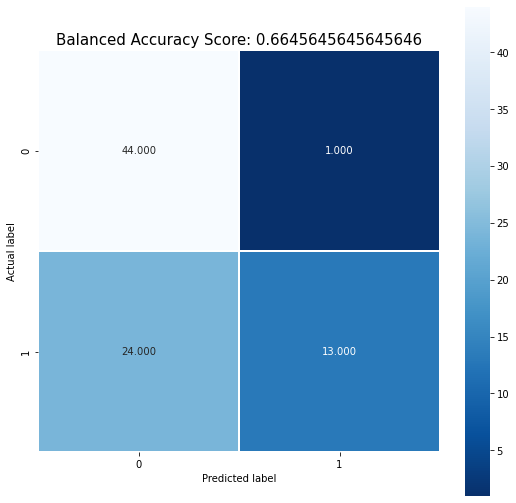

In [28]:
# make prediction
pred_pears_smote = clf_pearson_smote.predict(X_testPSMOTE)

# calculate ballanced accuracy
bscore_pears_smote = balanced_accuracy_score(y_testPSMOTE, pred_pears_smote)

# plot decision matrix
cm = confusion_matrix(y_testPSMOTE, pred_pears_smote)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Balanced Accuracy Score: {0}'.format(bscore_pears_smote)
plt.title(all_sample_title, size = 15);

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

print('Balanced Accuracy: {}'.format(bscore_pears_smote))
print('Cross Validation Score: {}'.format(str(cross_val_score(clf_pearson_smote, X, y, cv=10).mean())))
print('Recall: {}'.format(recall_score(y_testPSMOTE, pred_pears_smote, average='weighted')))
print('Precision: {}'.format(precision_score(y_testPSMOTE, pred_pears_smote, average='weighted')))
print('Accuracy: {}'.format(accuracy_score(y_testPSMOTE, pred_pears_smote)))

Balanced Accuracy: 0.6645645645645646
Cross Validation Score: 0.6506707317073172
Recall: 0.6951219512195121
Precision: 0.7740828038532488
Accuracy: 0.6951219512195121


#  (Pearson) Undersampling
# Prototype Generation

In [30]:
dfPGPearson = pearson_normalized.copy(deep=True)

In [31]:
from imblearn.under_sampling import ClusterCentroids

# initiate RandomOverSampler
cc = ClusterCentroids()

# split dataset into X and y
y = dfPGPearson.pop('DEATH_EVENT')
X = dfPGPearson
y.head()
X_resampled, y_resampled = cc.fit_resample(X, y)
dfPGPearsRes = pd.DataFrame(X_resampled, columns=X.columns)
dfPGPearsRes['DEATH_EVENT'] = y_resampled
y = dfPGPearsRes['DEATH_EVENT']
X = dfPGPearsRes[[i for i in dfPGPearsRes.columns if i != 'DEATH_EVENT']]

Train/Test Split

In [32]:
from sklearn.model_selection import train_test_split
trainPPG, testPPG = train_test_split(dfPGPearsRes, test_size=0.2)
y_trainPPG = trainPPG.pop('DEATH_EVENT')
X_trainPPG = trainPPG
y_testPPG = testPPG.pop('DEATH_EVENT')
X_testPPG = testPPG
y = dfPGPearsRes.pop('DEATH_EVENT')
X = dfPGPearsRes

In [33]:
X_trainPPG.describe()

,age,ejection_fraction,serum_creatinine,time
count,153.000000,153.000000,153.000000,153.000000
mean,0.136416,-0.037788,0.234243,-0.243178
std,1.092713,1.097590,1.256176,1.010908
min,-1.754448,-1.953749,-0.768683,-1.629502
25%,-0.878651,-1.107370,-0.381379,-1.151986
50%,-0.014054,-0.070555,-0.194181,-0.455071
75%,0.771889,0.585389,0.393231,0.641925
max,2.877170,3.547716,7.752020,1.997038


# (Pearson)(Prototype Generation)
# Classification with SVC, Gaussian Kernel

Select Proper Parameters (C and gamma)

Fit Model

In [34]:
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [35]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.31622776601683794, 'gamma': 1.0} with a score of 0.78


In [36]:
clf_pearson_PPG = SVC(gamma=grid.best_params_['C'], C=grid.best_params_['gamma'])
clf_pearson_PPG.fit(X_trainPSMOTE, y_trainPSMOTE)

SVC(gamma=0.31622776601683794)

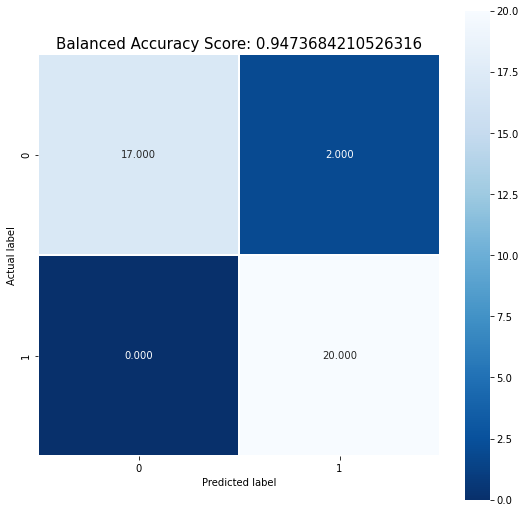

In [37]:
# make prediction
pred_pears_PG = clf_pearson_PPG.predict(X_testPPG)

# calculate ballanced accuracy
bscore_pears_PPG = balanced_accuracy_score(y_testPPG, pred_pears_PG)

# plot decision matrix
cm = confusion_matrix(y_testPPG, pred_pears_PG)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Balanced Accuracy Score: {0}'.format(bscore_pears_PPG)
plt.title(all_sample_title, size = 15);

In [38]:
print('Balanced Accuracy: {}'.format(bscore_pears_PPG))
print('Cross Validation Score: {}'.format(str(cross_val_score(clf_pearson_PPG, X, y, cv=10).mean())))
print('Recall: {}'.format(recall_score(y_testPPG, pred_pears_PG, average='weighted')))
print('Precision: {}'.format(precision_score(y_testPPG, pred_pears_PG, average='weighted')))
print('Accuracy: {}'.format(accuracy_score(y_testPPG, pred_pears_PG)))

Balanced Accuracy: 0.9473684210526316
Cross Validation Score: 0.7271052631578947
Recall: 0.9487179487179487
Precision: 0.9533799533799533
Accuracy: 0.9487179487179487


# Prototype Selection
# Condensed nearest neighbors 

In [39]:
dfCNNpearson = pearson_normalized.copy(deep=True)

In [40]:
from imblearn.under_sampling import CondensedNearestNeighbour

# initiate CNN resampler
cnn = CondensedNearestNeighbour(random_state=0)

# split dataset into X and y
y = dfCNNpearson.pop('DEATH_EVENT')
X = dfCNNpearson
y.head()
X_resampled, y_resampled = cnn.fit_resample(X, y)
dfCNNPearsRes = pd.DataFrame(X_resampled, columns=X.columns)
dfCNNPearsRes['DEATH_EVENT'] = y_resampled
y = dfCNNPearsRes['DEATH_EVENT']
X = dfCNNPearsRes[[i for i in dfCNNPearsRes.columns if i != 'DEATH_EVENT']]

Train/Test Split

In [41]:
trainPCNN, testPCNN = train_test_split(dfCNNPearsRes, test_size=0.2)
y_trainPCNN = trainPCNN.pop('DEATH_EVENT')
X_trainPCNN = trainPCNN
y_testPCNN = testPCNN.pop('DEATH_EVENT')
X_testPCNN = testPCNN
y = dfCNNPearsRes.pop('DEATH_EVENT')
X = dfCNNPearsRes

In [42]:
X_trainPCNN.describe()

,age,ejection_fraction,serum_creatinine,time
count,118.000000,118.000000,118.000000,118.000000
mean,0.213574,-0.241624,0.263008,-0.575380
std,1.062898,1.126138,1.341766,0.895344
min,-1.670236,-2.038387,-0.865509,-1.603691
25%,-0.638649,-1.107370,-0.381379,-1.303630
50%,-0.070223,-0.472585,-0.187726,-0.777717
75%,0.771889,0.162199,0.415017,-0.006593
max,2.877170,2.701337,7.752020,1.545334


# (Pearson)(Condensed Nearest Neighbors)
# Classification with SVC, Gaussian Kernel

Select Proper Parameters (C and gamma)

In [43]:
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [44]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 3.1622776601683795, 'gamma': 0.1} with a score of 0.73


In [47]:
clf_pearson_CNN = SVC(gamma=grid.best_params_['gamma'], C=grid.best_params_['C'])
clf_pearson_CNN.fit(X_trainPCNN, y_trainPCNN)

SVC(C=3.1622776601683795, gamma=0.1)

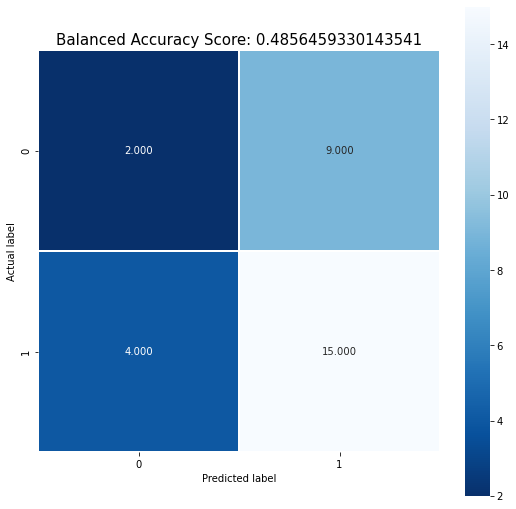

In [48]:
# make prediction
pred_pears_CNN = clf_pearson_CNN.predict(X_testPCNN)

# calculate ballanced accuracy
bscore_pears_CNN = balanced_accuracy_score(y_testPCNN, pred_pears_CNN)

# plot decision matrix
cm = confusion_matrix(y_testPCNN, pred_pears_CNN)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Balanced Accuracy Score: {0}'.format(bscore_pears_CNN)
plt.title(all_sample_title, size = 15);

In [52]:
print('Balanced Accuracy: {}'.format(bscore_pears_CNN))
print('Cross Validation Score: {}'.format(str(cross_val_score(clf_pearson_CNN, X, y, cv=10).mean())))
print('Recall: {}'.format(recall_score(y_testPCNN, pred_pears_CNN, average='weighted')))
print('Precision: {}'.format(precision_score(y_testPCNN, pred_pears_CNN, average='weighted')))
print('Accuracy: {}'.format(accuracy_score(y_testPCNN, pred_pears_CNN)))

Balanced Accuracy: 0.4856459330143541
Cross Validation Score: 0.6871428571428572
Recall: 0.5666666666666667
Precision: 0.5180555555555555
Accuracy: 0.5666666666666667


# (Pearson) More Over Sampling
# K-means SMOTE

In [57]:
dfPearsKMS = pearson_normalized.copy(deep=True)

In [58]:
from imblearn.over_sampling import KMeansSMOTE

KMS = KMeansSMOTE()
y = dfPearsKMS.pop('DEATH_EVENT')
X = dfPearsKMS
X_resampled, y_resampled = KMS.fit_resample(X, y)
dfPearsKMSres = pd.DataFrame(X_resampled, columns=X.columns)
dfPearsKMSres['DEATH_EVENT'] = y_resampled

In [59]:
trainPKMS, testPKMS = train_test_split(dfPearsKMSres, test_size=0.2)
y_trainPKMS = trainPKMS.pop('DEATH_EVENT')
X_trainPKMS = trainPKMS
y_testPKMS = testPKMS.pop('DEATH_EVENT')
X_testPKMS = testPKMS

In [60]:
X_trainPKMS.head()

,age,ejection_fraction,serum_creatinine,time
310,-1.455518,-1.997472,-0.340996,-1.182262
2,0.350833,-1.530560,-0.090900,-1.590785
352,-0.200555,0.452321,4.485258,-1.295955
55,2.877170,-0.684180,0.586883,-1.035834
351,0.087909,1.809674,5.470906,-1.166162


# (KmeansSMOTE)
# SVC With Gaussian Kernel

In [61]:
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [62]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 31.622776601683793, 'gamma': 0.01} with a score of 0.82


In [63]:
clf_pearson_KMS = SVC(gamma=grid.best_params_['gamma'], C=grid.best_params_['C'])
clf_pearson_KMS.fit(X_trainPKMS, y_trainPKMS)

SVC(C=31.622776601683793, gamma=0.01)

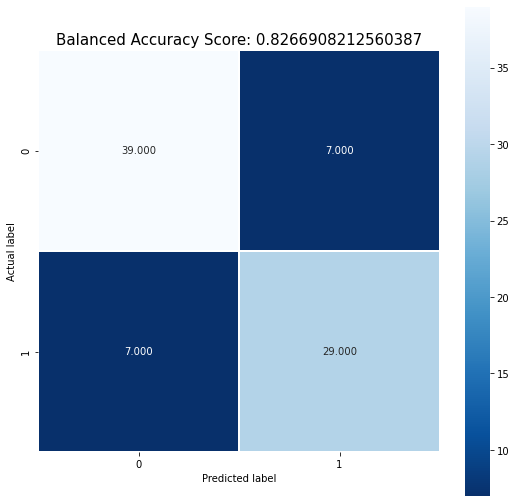

In [65]:
# make prediction
pred_pears_KMS = clf_pearson_KMS.predict(X_testPKMS)

# calculate ballanced accuracy
bscore_pears_KMS = balanced_accuracy_score(y_testPKMS, pred_pears_KMS)

# plot decision matrix
cm = confusion_matrix(y_testPKMS, pred_pears_KMS)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Balanced Accuracy Score: {0}'.format(bscore_pears_KMS)
plt.title(all_sample_title, size = 15);

In [67]:
print('Balanced Accuracy: {}'.format(bscore_pears_KMS))
print('Cross Validation Score: {}'.format(str(cross_val_score(clf_pearson_KMS, X, y, cv=10).mean())))
print('Recall: {}'.format(recall_score(y_testPKMS, pred_pears_KMS, average='weighted')))
print('Precision: {}'.format(precision_score(y_testPKMS, pred_pears_KMS, average='weighted')))
print('Accuracy: {}'.format(accuracy_score(y_testPKMS, pred_pears_KMS)))

Balanced Accuracy: 0.8266908212560387
Cross Validation Score: 0.8122988505747127
Recall: 0.8292682926829268
Precision: 0.8292682926829268
Accuracy: 0.8292682926829268


# (Pearson) Using Class Weights with SVC

In [68]:
df_weighted = pearson_normalized.copy(deep=True)

Train/Test Split

In [70]:
y = df_weighted['DEATH_EVENT']
X = df_weighted[[i for i in dfRandPearsRes.columns if i != 'DEATH_EVENT']]

trainW, testW = train_test_split(df_weighted, test_size=0.2)
y_trainW = trainW.pop('DEATH_EVENT')
X_trainW = trainW
y_testW = testW.pop('DEATH_EVENT')
X_testW = testW

In [73]:
cw={0:203,1:96}

param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(class_weight=cw), param_grid=param_grid, cv=cv)
grid.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(class_weight={0: 203, 1: 96}),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [74]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1.0, 'gamma': 0.01} with a score of 0.83


In [76]:
SVMw = SVC(gamma=grid.best_params_['gamma'], C=grid.best_params_['C'],class_weight=cw)
SVMw.fit(X_trainW, y_trainW)

SVC(class_weight={0: 203, 1: 96}, gamma=0.01)

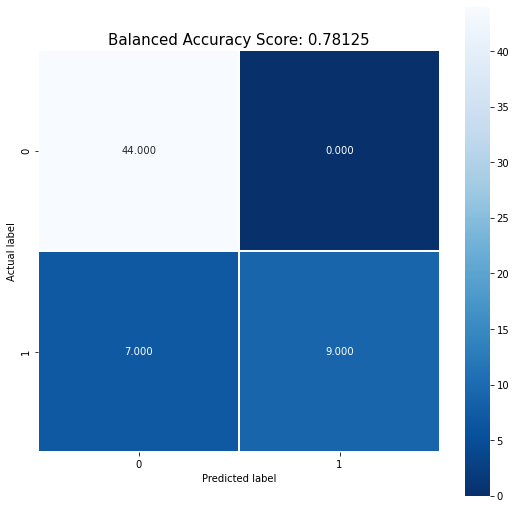

In [78]:
pred_pears_W = SVMw.predict(X_testW)

# calculate ballanced accuracy
bscore_pears_W = balanced_accuracy_score(y_testW, pred_pears_W)

# plot decision matrix
cm = confusion_matrix(y_testW, pred_pears_W)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Balanced Accuracy Score: {0}'.format(bscore_pears_W)
plt.title(all_sample_title, size = 15);

In [80]:
print('Balanced Accuracy: {}'.format(bscore_pears_W))
print('Cross Validation Score: {}'.format(str(cross_val_score(SVMw, X, y, cv=10).mean())))
print('Recall: {}'.format(recall_score(y_testW, pred_pears_W, average='weighted')))
print('Precision: {}'.format(precision_score(y_testW, pred_pears_W, average='weighted')))
print('Accuracy: {}'.format(accuracy_score(y_testW, pred_pears_W)))

Balanced Accuracy: 0.78125
Cross Validation Score: 0.7956321839080459
Recall: 0.8833333333333333
Precision: 0.8993464052287582
Accuracy: 0.8833333333333333
